In [1]:
# Imports
import pickle

from re import subn
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from analyzer import data_cleaner
from analyzer.data_transformation import TfidfDataTransformer, BagOfWordsTransformer, DataTransformer

from imblearn.under_sampling import TomekLinks,RandomUnderSampler, CondensedNearestNeighbour,EditedNearestNeighbours

from sklearn.linear_model import LogisticRegression

In [5]:
#Load data

def load_and_clean_data(filepath, rename_dict=None, vectorizer_output='models/vectorizer.sav', **kwargs) -> (pd.DataFrame, DataTransformer):
    # Load data
    df = pd.read_csv(filepath, **kwargs)

    if rename_dict is not None:
        df.rename(columns=rename_dict, inplace=True)
    display(df.head(5))
    # Clean data
        # Remove @ mentions
    df['clean_text'] = np.vectorize(data_cleaner.clean_mentions)(df['text'])
        # Remove non alfabet chars
    df['clean_text'] = df['clean_text'].str.replace("[^a-zA-Z#]", " ")
        # Remove short words
    df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # Transform
    tr = TfidfDataTransformer()
    # Stemming
    df['clean_text'] = tr.stemming(df['clean_text'])

    tr.vectorizer_fit(df['clean_text'])
    df_tfidf = tr.transform(df['clean_text'])
    pickle.dump(tr.vectorizer, open(vectorizer_output, 'wb'))


    return df, df_tfidf, tr

def balance_data(X, y, balancer = RandomUnderSampler(sampling_strategy='not minority',random_state=1337)) -> pd.DataFrame:
    X_balanced, y_balanced = balancer.fit_resample(X, y)
    return X_balanced, y_balanced



def fit_model(X, y, model_type, params, model_output='../models/model.sav', ):
    model = model_type(**params)
    model.fit(X,y)
    if model_output is not None:
        pickle.dump(model, open(model_output, 'wb'))
    return model

proba_models = set(['LogisticRegression'])
def predict(model, data):
    model_name = type(model).__name__
    if model_name in proba_models:
        predictions = model.predict_proba(data)
    else:
        predictions = model.predict(data)
    return predictions

def metrics(predictions, true_values, name_prefix="", plot=True):
    predictions_int =  predictions[:,1]>=0.3
    # Calculate metrics
    metrics = {
        'f1_score': f1_score(true_values, predictions_int),
        'confusion_matrix': confusion_matrix(true_values, predictions_int)
    }
    # Plot?? mby
    if plot:
        ConfusionMatrixDisplay.from_predictions(true_values, predictions_int)
        plt.show()
    # Write to outputfile.
    with open(f'out/results/{name_prefix}_out.out', 'w') as f:
            f.write(str(metrics))
    return metrics

In [6]:
def __model_tuning__(X_train, y_train, X_valid, y_valid, model_type,params, output_file, data_label=""):
    output_name = f'{model_type.__name__}-$-{data_label}-{datetime.now().timestamp()}'
    model_output = f'models/{output_name}.sav'
    outputs = []
    for p in ParameterGrid(params):
        model_output = model_output.replace('$',subn("[{}',:]","","".join(str(p).split()))[0])
        model = fit_model(X_train, y_train, model_type, params=p, model_output=model_output)
        predictions = predict(model, X_valid)
        output = metrics(predictions, y_valid, output_name.replace('$',subn("[{}',:]","","".join(str(p).split()))[0]))
        outputs.append(output)
    return outputs


,id,output,text
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


C:\Users\Tomiu\AppData\Local\Temp\ipykernel_16988\1673807029.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['clean_text'].str.replace("[^a-zA-Z#]", " ")


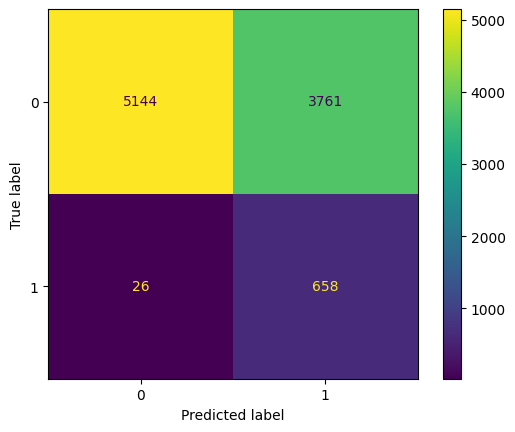

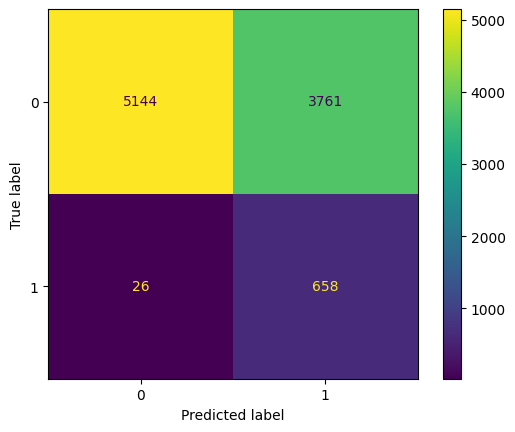

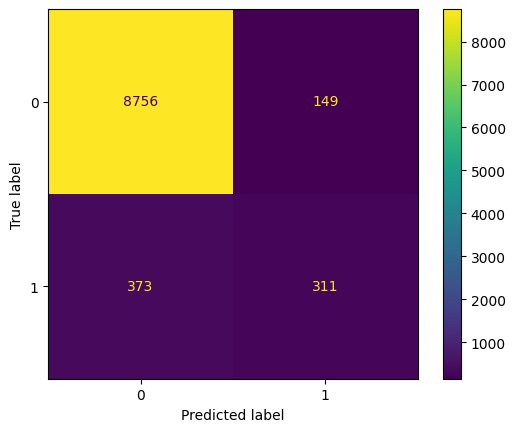

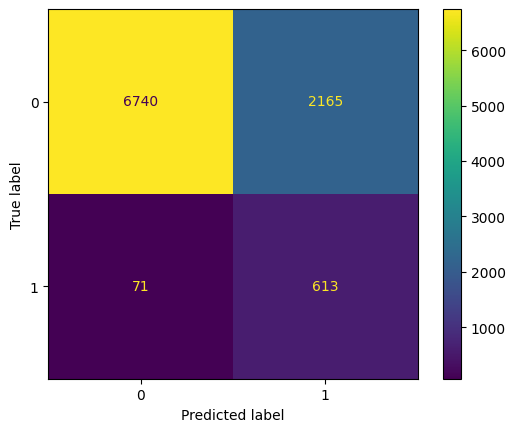

In [7]:
df, df_tfidf, tr = load_and_clean_data('data/train.csv', rename_dict={'tweet':'text', 'label':'output'})

X_train, X_valid, y_train, y_valid = train_test_split(df_tfidf, df['output'],test_size=0.3,random_state=42)

X_train_balanced, y_train_balanced = balance_data(X_train, y_train)

param_grid = {'penalty': [ 'l2'], 'class_weight': [None,'balanced'], 'solver':['newton-cholesky'], 'n_jobs':[-1]}

output = __model_tuning__(X_train_balanced, y_train_balanced, X_valid, y_valid, LogisticRegression, param_grid, 'lin_reg_1' ,'bal')
output2 = __model_tuning__(X_train, y_train, X_valid, y_valid, LogisticRegression, param_grid, 'lin_reg_1' ,'unba')